# Graph Basics & Connections

This notebook demonstrates:
1. **Setup & Connection Management** - Initialize Redis and Memgraph
2. **Loading Graph Data** - Query node and relationship data from Memgraph
3. **Basic Cypher Queries** - Execute queries against Memgraph
4. **Graph Statistics & Visualization** - Explore the code graph structure

**Data Source**: Code-graph-mcp repository (analyzed nodes and relationships in Memgraph)
**Analysis Type**: Local graph analysis with NetworkX visualization


## Section 1: Setup & Connection Management

Initialize connections to Redis (CDC events) and Memgraph (graph queries).


In [32]:
# Import required libraries
import os
import sys
import asyncio
import json
from typing import Dict, List, Optional, Any
from dataclasses import dataclass
from datetime import datetime

# Data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

# Async HTTP and database clients
import httpx
import redis.asyncio as redis
from neo4j import GraphDatabase
from neo4j.exceptions import ServiceUnavailable

print("✅ Libraries imported successfully")

# Configure visualization
plt.style.use('dark_background')
%matplotlib inline

print("✅ Visualization configured")

✅ Libraries imported successfully
✅ Visualization configured


In [33]:
# Add utilities to path
sys.path.insert(0, '/home/jovyan/work/utils')

# Detect if running in container and adjust hostnames
import socket
import os

IN_CONTAINER = False # os.path.exists('/.dockerenv')
HOST_ALIAS = 'host.docker.internal' if IN_CONTAINER else 'localhost'

# Load environment variables with container-aware defaults
REDIS_URL = os.getenv('REDIS_URL', f'redis://{HOST_ALIAS}:6379')
MEMGRAPH_URL = os.getenv('MEMGRAPH_URL', f'bolt://{HOST_ALIAS}:7687')

print(f"📌 Environment: {'Container' if IN_CONTAINER else 'Host'}")
print(f"📌 Redis: {REDIS_URL}")
print(f"📌 Memgraph: {MEMGRAPH_URL}")


📌 Environment: Host
📌 Redis: redis://localhost:6379
📌 Memgraph: bolt://localhost:7687


In [34]:
# Helper class for managing connections
class GraphConnections:
    """Manages connections to Redis and Memgraph"""
    
    def __init__(self, redis_url: str, memgraph_url: str):
        self.redis_url = redis_url
        self.memgraph_url = memgraph_url
        
        self.redis_client = None
        self.memgraph_driver = None
    
    async def connect(self):
        """Establish all connections with detailed error reporting"""
        print(f"Connecting to: {self.redis_url}, {self.memgraph_url}\n")
        
        # Try Redis
        try:
            self.redis_client = await redis.from_url(self.redis_url, decode_responses=True)
            await self.redis_client.ping()
            print(f"✅ Redis connected ({self.redis_url})")
        except Exception as e:
            print(f"❌ Redis failed: {type(e).__name__}: {e}")
            print(f"   Trying fallback: redis://localhost:6379")
            try:
                self.redis_client = await redis.from_url('redis://localhost:6379', decode_responses=True)
                await self.redis_client.ping()
                print(f"✅ Redis connected (fallback to localhost)")
            except Exception as e2:
                print(f"❌ Redis fallback also failed: {type(e2).__name__}: {e2}")
        
        # Try Memgraph
        try:
            driver = GraphDatabase.driver(self.memgraph_url)
            with driver.session() as session:
                session.run("RETURN 1")
            self.memgraph_driver = driver
            print(f"✅ Memgraph connected ({self.memgraph_url})")
        except ServiceUnavailable as e:
            print(f"⚠️  Memgraph unavailable: {e}")
            print(f"   Trying fallback: bolt://localhost:7687")
            try:
                driver = GraphDatabase.driver('bolt://localhost:7687')
                with driver.session() as session:
                    session.run("RETURN 1")
                self.memgraph_driver = driver
                print(f"✅ Memgraph connected (fallback to localhost)")
            except Exception as e2:
                print(f"❌ Memgraph fallback also failed: {type(e2).__name__}: {e2}")
        except Exception as e:
            print(f"❌ Memgraph failed: {type(e).__name__}: {e}")
            print(f"   Trying fallback: bolt://localhost:7687")
            try:
                driver = GraphDatabase.driver('bolt://localhost:7687')
                with driver.session() as session:
                    session.run("RETURN 1")
                self.memgraph_driver = driver
                print(f"✅ Memgraph connected (fallback to localhost)")
            except Exception as e2:
                print(f"❌ Memgraph fallback also failed: {type(e2).__name__}: {e2}")
    
    async def close(self):
        """Close all connections"""
        if self.redis_client:
            await self.redis_client.aclose()
        if self.memgraph_driver:
            self.memgraph_driver.close()
        print("✅ All connections closed")

# Initialize connections
connections = GraphConnections(REDIS_URL, MEMGRAPH_URL)

# For Jupyter, use await directly (Jupyter has a running event loop)
await connections.connect()

print("\n✅ All systems initialized!")


Connecting to: redis://localhost:6379, bolt://localhost:7687

✅ Redis connected (redis://localhost:6379)
✅ Memgraph connected (bolt://localhost:7687)

✅ All systems initialized!


## Section 2: Loading Graph Data & Statistics

Fetch basic graph statistics from the backend API. This shows the current state of the analyzed codebase.

📊 Graph Statistics:
   • Nodes: 1009
   • Relationships: 2
   • Languages: python
   • Entry Points: 0


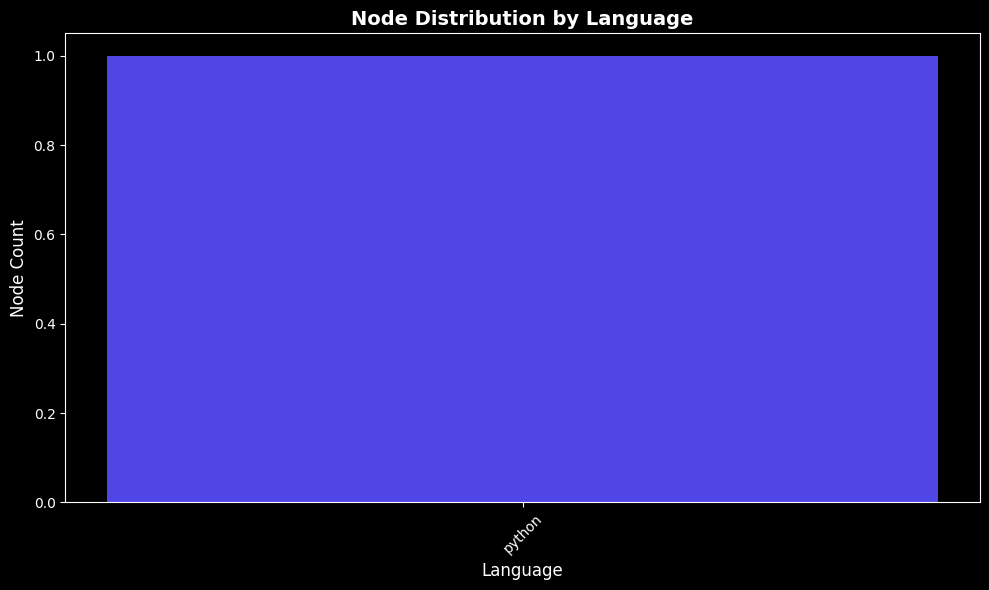


✅ Graph loaded with 1009 nodes


In [35]:
async def get_graph_stats():
    """Fetch graph statistics from Memgraph"""
    if not connections.memgraph_driver:
        print("❌ Memgraph not available")
        return None
    
    try:
        with connections.memgraph_driver.session() as session:
            # Get node and relationship counts
            nodes_result = session.run("MATCH (n) RETURN count(n) as total_nodes")
            nodes_count = nodes_result.single()['total_nodes']
            
            rels_result = session.run("MATCH ()-[r]->() RETURN count(r) as total_rels")
            rels_count = rels_result.single()['total_rels']
            
            # Get languages
            langs_result = session.run("""
                MATCH (n:Function)
                WHERE n.language IS NOT NULL
                RETURN DISTINCT n.language as lang
            """)
            languages = [record['lang'] for record in langs_result]
            
            # Get entry points count
            entry_result = session.run("""
                MATCH (n:Function {is_entry_point: true})
                RETURN count(n) as entry_points
            """)
            entry_count = entry_result.single()['entry_points']
            
            # Get nodes by language
            lang_dist_result = session.run("""
                MATCH (n:Function)
                WHERE n.language IS NOT NULL
                RETURN n.language as language, count(n) as count
                ORDER BY count DESC
            """)
            nodes_by_language = {record['language']: record['count'] for record in lang_dist_result}
            
            return {
                'total_nodes': nodes_count,
                'total_relationships': rels_count,
                'languages': languages,
                'entry_points': entry_count,
                'nodes_by_language': nodes_by_language
            }
    except Exception as e:
        print(f"Error fetching stats: {e}")
        return None

# Fetch and display stats
stats = await get_graph_stats()

if stats:
    print("📊 Graph Statistics:")
    print(f"   • Nodes: {stats.get('total_nodes', 0)}")
    print(f"   • Relationships: {stats.get('total_relationships', 0)}")
    print(f"   • Languages: {', '.join(stats.get('languages', []))}")
    print(f"   • Entry Points: {stats.get('entry_points', 0)}")
    
    # Visualize node distribution by language
    if 'nodes_by_language' in stats and stats['nodes_by_language']:
        lang_dist = stats['nodes_by_language']
        
        plt.figure(figsize=(10, 6))
        plt.bar(lang_dist.keys(), lang_dist.values(), color='#4F46E5')
        plt.xlabel('Language', fontsize=12)
        plt.ylabel('Node Count', fontsize=12)
        plt.title('Node Distribution by Language', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        print(f"\n✅ Graph loaded with {stats.get('total_nodes', 0)} nodes")
else:
    print("⚠️  Could not fetch graph statistics")


In [36]:
async def get_all_nodes():
    """Fetch all nodes from Memgraph"""
    if not connections.memgraph_driver:
        print("❌ Memgraph not available")
        return pd.DataFrame()
    
    try:
        with connections.memgraph_driver.session() as session:
            result = session.run("""
                MATCH (n)
                RETURN 
                    n.name as name,
                    labels(n)[0] as type,
                    n.file as file,
                    n.language as language,
                    n.lineno as lineno
                LIMIT 1000
            """)
            nodes = [record.data() for record in result]
            return pd.DataFrame(nodes)
    except Exception as e:
        print(f"Error fetching nodes: {e}")
        return pd.DataFrame()

# Fetch nodes
nodes_df = await get_all_nodes()

if not nodes_df.empty:
    print(f"Loaded {len(nodes_df)} nodes")
    print("\nFirst 10 nodes:")
    display_cols = [col for col in ['name', 'type', 'file', 'language'] if col in nodes_df.columns]
    print(nodes_df.head(10)[display_cols].to_string())
    
    # Show node type distribution
    if 'type' in nodes_df.columns:
        print("\n\nNode Type Distribution:")
        print(nodes_df['type'].value_counts())
else:
    print("⚠️  Could not fetch nodes")


Loaded 1000 nodes

First 10 nodes:
     name      type  file language
0   func1  Function  None   python
1   func1   Unknown  None     None
2   func2   Unknown  None     None
3  node_0   Unknown  None     None
4  node_1   Unknown  None     None
5  node_2   Unknown  None     None
6  node_3   Unknown  None     None
7  node_4   Unknown  None     None
8    None   Unknown  None     None
9  node_0  Function  None     None


Node Type Distribution:
type
Function    992
Unknown       8
Name: count, dtype: int64


## Section 3: Basic Cypher Queries (via Memgraph)

If Memgraph is available, execute Cypher queries to explore the graph structure.

In [37]:
def run_cypher_query(query: str, params: Dict = None) -> List[Dict]:
    """Execute a Cypher query against Memgraph"""
    if not connections.memgraph_driver:
        print("⚠️  Memgraph not available")
        return []
    
    try:
        with connections.memgraph_driver.session() as session:
            result = session.run(query, params or {})
            return [record.data() for record in result]
    except Exception as e:
        print(f"Query error: {e}")
        return []

# Query 1: Entry points (top-level functions)
print("🔍 Query 1: Entry Points (Top-level functions)\n")
query1 = """
MATCH (f:Function {is_entry_point: true})
RETURN f.name as name, f.file as file, f.language as language
LIMIT 20
"""
results = run_cypher_query(query1)
if results:
    entry_points_df = pd.DataFrame(results)
    print(entry_points_df.to_string())
    print(f"\nFound {len(results)} entry points")
else:
    print("No results or Memgraph unavailable")

🔍 Query 1: Entry Points (Top-level functions)

No results or Memgraph unavailable


In [38]:
print("\n" + "="*60)
print("🔍 Query 2: Function Hubs (Most called functions)\n")

query2 = """
MATCH (f:Function)<-[:CALLS]-(callers)
WITH f, count(callers) as caller_count
WHERE caller_count > 2
RETURN f.name as name, f.file as file, caller_count
ORDER BY caller_count DESC
LIMIT 15
"""
results = run_cypher_query(query2)
if results:
    hubs_df = pd.DataFrame(results)
    print(hubs_df.to_string())
    
    # Visualize top hubs
    plt.figure(figsize=(12, 6))
    top_10 = hubs_df.head(10)
    plt.barh(top_10['name'], top_10['caller_count'], color='#EC4899')
    plt.xlabel('Number of Callers', fontsize=12)
    plt.title('Top 10 Function Hubs (Most Called)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print(f"\n✅ Found {len(results)} function hubs")
else:
    print("No results or Memgraph unavailable")


🔍 Query 2: Function Hubs (Most called functions)

No results or Memgraph unavailable


In [39]:
print("\n" + "="*60)
print("🔍 Query 3: Call Chain Analysis\n")

# Find a function and trace its callers
if not nodes_df.empty:
    sample_function = nodes_df[nodes_df['type'] == 'Function'].iloc[0]['name']
    
    query3 = f"""
    MATCH path = (caller:Function)-[:CALLS*1..3]->(:Function {{name: '{sample_function}'}})
    RETURN 
        length(path) as distance,
        [node in nodes(path) | node.name] as call_path
    ORDER BY distance
    LIMIT 10
    """
    
    print(f"Analyzing callers of function: {sample_function}\n")
    results = run_cypher_query(query3)
    
    if results:
        for i, result in enumerate(results[:5], 1):
            path = " → ".join(result['call_path'])
            print(f"{i}. [{result['distance']} hops] {path}")
    else:
        print("No call paths found or Memgraph unavailable")


🔍 Query 3: Call Chain Analysis

Analyzing callers of function: func1

No call paths found or Memgraph unavailable


## Section 4: Building NetworkX Graph from Backend Data

Create an in-memory NetworkX graph for fast local analysis and visualization.

In [40]:
async def get_all_relationships():
    """Fetch all relationships from Memgraph"""
    if not connections.memgraph_driver:
        print("❌ Memgraph not available")
        return []
    
    try:
        with connections.memgraph_driver.session() as session:
            result = session.run("""
                MATCH (source)-[r]->(target)
                RETURN 
                    source.name as source_name,
                    target.name as target_name,
                    type(r) as relationship_type
                LIMIT 5000
            """)
            return [record.data() for record in result]
    except Exception as e:
        print(f"Error fetching relationships: {e}")
        return []

# Build NetworkX graph
print("🔨 Building NetworkX graph...\n")

# Create directed graph
G = nx.DiGraph()

# Add nodes
if not nodes_df.empty:
    for idx, row in nodes_df.iterrows():
        G.add_node(row['name'], 
                   type=row.get('type'), 
                   file=row.get('file'),
                   language=row.get('language'))
    print(f"✅ Added {len(nodes_df)} nodes")

# Add edges
relationships = await get_all_relationships()
for rel in relationships:
    if rel.get('source_name') in G and rel.get('target_name') in G:
        G.add_edge(rel['source_name'], rel['target_name'], 
                   relationship_type=rel.get('relationship_type'))

print(f"✅ Added {G.number_of_edges()} edges")
print(f"\nGraph Statistics:")
print(f"   • Nodes: {G.number_of_nodes()}")
print(f"   • Edges: {G.number_of_edges()}")
print(f"   • Density: {nx.density(G):.4f}")
if G.number_of_nodes() > 0:
    try:
        print(f"   • Diameter: {nx.diameter(G) if nx.is_strongly_connected(G) else 'N/A (disconnected)'}")
    except:
        print(f"   • Diameter: N/A (no path exists)")


🔨 Building NetworkX graph...



ValueError: None cannot be a node

In [ ]:
print("\n" + "="*60)
print("📈 Basic Graph Analysis\n")

# In-degree distribution (how many functions call each function)
in_degrees = dict(G.in_degree())
top_called = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Most Called Functions:")
for func, degree in top_called:
    print(f"   {func}: {degree} callers")

# Out-degree distribution (how many functions each function calls)
out_degrees = dict(G.out_degree())
top_callers = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 Functions That Call Most Others:")
for func, degree in top_callers:
    print(f"   {func}: {degree} calls")

# Visualize degree distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# In-degree histogram
in_degree_values = list(in_degrees.values())
axes[0].hist(in_degree_values, bins=50, color='#4F46E5', alpha=0.7)
axes[0].set_xlabel('In-Degree (Number of Callers)', fontsize=11)
axes[0].set_ylabel('Number of Functions', fontsize=11)
axes[0].set_title('In-Degree Distribution', fontsize=12, fontweight='bold')
axes[0].set_yscale('log')

# Out-degree histogram
out_degree_values = list(out_degrees.values())
axes[1].hist(out_degree_values, bins=50, color='#EC4899', alpha=0.7)
axes[1].set_xlabel('Out-Degree (Number of Calls)', fontsize=11)
axes[1].set_ylabel('Number of Functions', fontsize=11)
axes[1].set_title('Out-Degree Distribution', fontsize=12, fontweight='bold')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\n✅ Analysis complete")

## Summary

This notebook demonstrated:

1. ✅ **Connection Setup** - Initialized async connections to Redis, Memgraph, and Backend API
2. ✅ **Graph Statistics** - Loaded and visualized graph metadata
3. ✅ **Cypher Queries** - Executed queries against Memgraph (entry points, hubs, call chains)
4. ✅ **NetworkX Analysis** - Built in-memory graph for local analysis
5. ✅ **Degree Analysis** - Identified hubs and leaf nodes

### Next Steps:
- **Notebook 02**: Centrality Analysis (PageRank, betweenness, closeness)
- **Notebook 03**: Community Detection (Louvain algorithm, module boundaries)
- **Notebook 04**: Architectural Patterns (seams, coupling, god functions)
- **Notebook 05**: Ontology Extraction (domain vocabulary, concept mapping)
- **Notebook 06**: C4 Diagram Generation (architecture visualization)